# Case study - estimating global liquidity

Main idea - when there's liquidity available, line of least resistance for risky assets is up, otherwise it's down.

Let's describe the process of gathering that data.

I'll start from tradingview formula that can be copy pasted to have a quick look at the visual representation.

* `FRED:WALCL+FRED:JPNASSETS*FX_IDC:JPYUSD+ECONOMICS:CNCBBS*FX_IDC:CNYUSD+FRED:ECBASSETSW*FX:EURUSD-FRED:RRPONTSYD-FRED:WTREGEN`

How do we get that?

In [1]:
import pandas_datareader as pdr

start_date = '2020-01-01'  # specify the start date
end_date = '2023-04-19'  # specify the end date

# download the data from FRED
fred_data = pdr.DataReader('WALCL', 'fred', start_date, end_date)

print(fred_data)

                WALCL
DATE                 
2020-01-01  4173626.0
2020-01-08  4149544.0
2020-01-15  4175850.0
2020-01-22  4145912.0
2020-01-29  4151630.0
...               ...
2023-03-15  8639300.0
2023-03-22  8733787.0
2023-03-29  8705942.0
2023-04-05  8632384.0
2023-04-12  8614797.0

[172 rows x 1 columns]


We can, in a pretty straightforward way, obtain the data for all pieces of the data available at FRED.

In [2]:
fred_symbols = ['WALCL', 'JPNASSETS', 'ECBASSETSW', 'RRPONTSYD', 'WTREGEN']

In [3]:
fred_data = {}

for symbol in fred_symbols:
    symbol_data = pdr.DataReader(symbol, 'fred', start_date, end_date)
    fred_data[symbol] = symbol_data

We don't care at the moment about the format/shape of the data, now let's get it in a raw format and when we have all in place, we'll do the reshaping and other preprocessing.

In [4]:
fx_symbols = ['JPY=X', 'EURUSD=X', 'CNY=X']

We need to obtain some data on currencies paired with USD to express all parts of the liquidity equation in the same unit - USD.

Simple way to do that is to use a `yfinance` API.

In [5]:
import yfinance as yf

start = '2010-01-01'
end = '2023-04-19'
interval = '1d'

yfin_data = yf.download(tickers='JPY=X',
                        start=start,
                        end=end,
                        interval=interval,
                        threads=False)

print(yfin_data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2010-01-01   92.940002   93.089996   92.919998   92.919998   92.919998       0
2010-01-04   92.760002   93.200996   92.196999   92.495003   92.495003       0
2010-01-05   92.470001   92.486000   91.282997   91.584999   91.584999       0
2010-01-06   91.550003   92.709999   91.522003   92.356003   92.356003       0
2010-01-07   92.335999   93.735001   92.110001   93.389999   93.389999       0
...                ...         ...         ...         ...         ...     ...
2023-04-12  133.593994  134.022995  132.781006  133.593994  133.593994       0
2023-04-13  133.085007  133.367004  132.029999  133.085007  133.085007       0
2023-04-14  132.487000  133.755997  132.175995  132.487000  132.487000       0
2023-04-17  133.970993  134.565002  133.714005  133.970993  13

In [6]:
fx_data = {}

for symbol in fx_symbols:
    symbol_data = yf.download(tickers=symbol,
                              start=start,
                              end=end,
                              interval=interval,
                              threads=False)
    fx_data[symbol] = symbol_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


And the remaining piece of data is `CNCBBS` - China Central Bank Balance Sheet.

I was unable to find an API to get this data in a way we got the previous samples (you can download it if you have tradingview Pro+ account).

After a couple minutes of browsing the internet and "hacking", you can find a hidden API with an endpoint that you can send request to:

* `https://www.fxempire.com/api/v1/en/macro-indicators/china/central-bank-balance-sheet/history?latest=60&frequency=Monthly`

A bit ugly but as the response is rather short, let's copy-paste that here.

In [7]:
rows = [{"formattedDate":"Mar 18","close":359608.4,"formattedClose":"359,608.4","timestamp":1522454400},{"formattedDate":"Apr 18","close":353225.27,"formattedClose":"353,225.27","timestamp":1525046400},{"formattedDate":"May 18","close":356149.44,"formattedClose":"356,149.44","timestamp":1527724800},{"formattedDate":"Jun 18","close":362702.44,"formattedClose":"362,702.44","timestamp":1530316800},{"formattedDate":"Jul 18","close":363282.97,"formattedClose":"363,282.97","timestamp":1532995200},{"formattedDate":"Aug 18","close":362616.86,"formattedClose":"362,616.86","timestamp":1535673600},{"formattedDate":"Sep 18","close":366229.75,"formattedClose":"366,229.75","timestamp":1538265600},{"formattedDate":"Oct 18","close":358337.97,"formattedClose":"358,337.97","timestamp":1540944000},{"formattedDate":"Nov 18","close":359069.94,"formattedClose":"359,069.94","timestamp":1543536000},{"formattedDate":"Dec 18","close":372492.06,"formattedClose":"372,492.06","timestamp":1546214400},{"formattedDate":"Jan 19","close":363271.82,"formattedClose":"363,271.82","timestamp":1548892800},{"formattedDate":"Feb 19","close":356209.39,"formattedClose":"356,209.39","timestamp":1551312000},{"formattedDate":"Mar 19","close":348552.63,"formattedClose":"348,552.63","timestamp":1553990400},{"formattedDate":"Apr 19","close":348592.42,"formattedClose":"348,592.42","timestamp":1556582400},{"formattedDate":"May 19","close":359014.72,"formattedClose":"359,014.72","timestamp":1559260800},{"formattedDate":"Jun 19","close":363595.27,"formattedClose":"363,595.27","timestamp":1561852800},{"formattedDate":"Jul 19","close":357952.87,"formattedClose":"357,952.87","timestamp":1564531200},{"formattedDate":"Aug 19","close":360352.9,"formattedClose":"360,352.9","timestamp":1567209600},{"formattedDate":"Sep 19","close":361966.76,"formattedClose":"361,966.76","timestamp":1569801600},{"formattedDate":"Oct 19","close":359640.48,"formattedClose":"359,640.48","timestamp":1572480000},{"formattedDate":"Nov 19","close":363075.36,"formattedClose":"363,075.36","timestamp":1575072000},{"formattedDate":"Dec 19","close":371130.48,"formattedClose":"371,130.48","timestamp":1577750400},{"formattedDate":"Jan 20","close":373495.1,"formattedClose":"373,495.1","timestamp":1580428800},{"formattedDate":"Feb 20","close":361021.26,"formattedClose":"361,021.26","timestamp":1582934400},{"formattedDate":"Mar 20","close":365374.74,"formattedClose":"365,374.74","timestamp":1585612800},{"formattedDate":"Apr 20","close":360347.67,"formattedClose":"360,347.67","timestamp":1588204800},{"formattedDate":"May 20","close":367870.74,"formattedClose":"367,870.74","timestamp":1590883200},{"formattedDate":"Jun 20","close":363931.3,"formattedClose":"363,931.3","timestamp":1593475200},{"formattedDate":"Jul 20","close":357924.9,"formattedClose":"357,924.9","timestamp":1596153600},{"formattedDate":"Aug 20","close":365052.29,"formattedClose":"365,052.29","timestamp":1598832000},{"formattedDate":"Sep 20","close":374727.69,"formattedClose":"374,727.69","timestamp":1601424000},{"formattedDate":"Oct 20","close":371812.72,"formattedClose":"371,812.72","timestamp":1604102400},{"formattedDate":"Nov 20","close":381989.33,"formattedClose":"381,989.33","timestamp":1606694400},{"formattedDate":"Dec 20","close":387675.54,"formattedClose":"387,675.54","timestamp":1609372800},{"formattedDate":"Jan 21","close":389131.46,"formattedClose":"389,131.46","timestamp":1612051200},{"formattedDate":"Feb 21","close":383093.17,"formattedClose":"383,093.17","timestamp":1614470400},{"formattedDate":"Mar 21","close":382772.77,"formattedClose":"382,772.77","timestamp":1617148800},{"formattedDate":"Apr 21","close":382315.47,"formattedClose":"382,315.47","timestamp":1619740800},{"formattedDate":"May 21","close":386916.77,"formattedClose":"386,916.77","timestamp":1622419200},{"formattedDate":"Jun 21","close":389897.36,"formattedClose":"389,897.36","timestamp":1625011200},{"formattedDate":"Jul 21","close":380501.62,"formattedClose":"380,501.62","timestamp":1627689600},{"formattedDate":"Aug 21","close":379487.47,"formattedClose":"379,487.47","timestamp":1630368000},{"formattedDate":"Sep 21","close":391973.65,"formattedClose":"391,973.65","timestamp":1632960000},{"formattedDate":"Oct 21","close":394919.35,"formattedClose":"394,919.35","timestamp":1635638400},{"formattedDate":"Nov 21","close":393114.26,"formattedClose":"393,114.26","timestamp":1638230400},{"formattedDate":"Dec 21","close":395702.25,"formattedClose":"395,702.25","timestamp":1640908800},{"formattedDate":"Jan 22","close":403125.23,"formattedClose":"403,125.23","timestamp":1643587200},{"formattedDate":"Feb 22","close":406229,"formattedClose":"406,229","timestamp":1646006400},{"formattedDate":"Mar 22","close":398725.89,"formattedClose":"398,725.89","timestamp":1648684800},{"formattedDate":"Apr 22","close":389336.03,"formattedClose":"389,336.03","timestamp":1651276800},{"formattedDate":"May 22","close":385319.77,"formattedClose":"385,319.77","timestamp":1653955200},{"formattedDate":"Jun 22","close":392554.6,"formattedClose":"392,554.6","timestamp":1656547200},{"formattedDate":"Jul 22","close":385627.47,"formattedClose":"385,627.47","timestamp":1659225600},{"formattedDate":"Aug 22","close":384642.28,"formattedClose":"384,642.28","timestamp":1661904000},{"formattedDate":"Sep 22","close":397402.27,"formattedClose":"397,402.27","timestamp":1664496000},{"formattedDate":"Oct 22","close":398871.25,"formattedClose":"398,871.25","timestamp":1667174400},{"formattedDate":"Nov 22","close":401527.62,"formattedClose":"401,527.62","timestamp":1669766400},{"formattedDate":"Dec 22","close":416783.78,"formattedClose":"416,783.78","timestamp":1672444800},{"formattedDate":"Jan 23","close":422064.71,"formattedClose":"422,064.71","timestamp":1675123200},{"formattedDate":"Feb 23","close":417679.36,"formattedClose":"417,679.36","timestamp":1677542400}]

In [8]:
import pandas as pd

df_cncbbs = pd.DataFrame(rows)

df_cncbbs.tail()

,formattedDate,close,formattedClose,timestamp
55,Oct 22,398871.25,"398,871.25",1667174400
56,Nov 22,401527.62,"401,527.62",1669766400
57,Dec 22,416783.78,"416,783.78",1672444800
58,Jan 23,422064.71,"422,064.71",1675123200
59,Feb 23,417679.36,"417,679.36",1677542400


## Combining all the liquidity pieces together

We want to prepare the dataset from 1st Jan 2020 to 15th Apr 2023 initially.

Let's prepare the shape of a final liquidity DataFrame and we'll worry about filling the values of each column later as different preprocessing will be needed for different columns.

In [9]:
df_liquidity = pd.DataFrame(columns=['date', 'walcl', 'jpnassets', 'cncbbs', 'ecbassetsw', 'rrpontsyd', 'wtregen'])

In [10]:
df_liquidity['date'] = [str(date)[:10] for date in pd.date_range('2020-01-01', '2023-04-19')]

The dataset is really small so let's do this step by step.

In [11]:
walcl_dts = [str(dt)[:10] for dt in fred_data['WALCL'].index]
walcl_idxs = df_liquidity[df_liquidity['date'].isin(walcl_dts)].index

df_liquidity['walcl'].loc[walcl_idxs] = fred_data['WALCL']['WALCL'].values
df_liquidity['walcl'] = df_liquidity['walcl'].ffill()

And we can repeat that for `RRPONTSYD` and `WTREGEN`.

In [12]:
for symbol in ['RRPONTSYD', 'WTREGEN']:
    symbol_dts = [str(dt)[:10] for dt in fred_data[symbol].index]
    symbol_idxs = df_liquidity[df_liquidity['date'].isin(symbol_dts)].index

    df_liquidity[symbol.lower()].loc[symbol_idxs] = fred_data[symbol][symbol].values
    df_liquidity[symbol.lower()] = df_liquidity[symbol.lower()].ffill()

C:\Users\WKSLA-HEU-mhalu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\WKSLA-HEU-mhalu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In case of `JPNASSETS`, `CNCBBS` and `ECBASSETSW` columns, we need to express their raw values in different currency.

In [13]:
import numpy as np

In [14]:
df_jpnassets = pd.DataFrame()
df_jpnassets['date'] = [str(dt)[:10] for dt in pd.date_range(df_liquidity['date'].min(), df_liquidity['date'].max())]

fx_dts = [str(dt)[:10] for dt in fx_data['JPY=X'].index if str(dt)[:10] >= df_jpnassets['date'].min()]
fx_idxs = df_jpnassets[df_jpnassets['date'].isin(fx_dts)].index
fx_values = fx_data['JPY=X'].loc[[dt for dt in fx_data['JPY=X'].index if str(dt)[:10] >= df_jpnassets['date'].min()]]['Close'].values
df_jpnassets['usd_jpy'] = np.nan
df_jpnassets['usd_jpy'].loc[fx_idxs] = fx_values
df_jpnassets['usd_jpy'] = df_jpnassets['usd_jpy'].ffill()

C:\Users\WKSLA-HEU-mhalu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
df_jpnassets['jpnassets'] = np.nan
values_dts = [str(dt)[:10] for dt in fred_data['JPNASSETS'].index]
values_idxs = df_jpnassets[df_jpnassets['date'].isin(values_dts)].index
df_jpnassets['jpnassets'].loc[values_idxs] = fred_data['JPNASSETS']['JPNASSETS'].values
df_jpnassets['jpnassets'] = df_jpnassets['jpnassets'].ffill()

C:\Users\WKSLA-HEU-mhalu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:
df_jpnassets['jpnassets_usd'] = df_jpnassets['jpnassets'] / df_jpnassets['usd_jpy']

In [17]:
all(df_jpnassets['date'] == df_liquidity['date'])

True

In [18]:
df_liquidity['jpnassets'] = df_jpnassets['jpnassets_usd'].values

In [19]:
df_liquidity.head()

,date,walcl,jpnassets,cncbbs,ecbassetsw,rrpontsyd,wtregen
0,2020-01-01,4173626.0,53214.011768,NaN,NaN,NaN,382.553
1,2020-01-02,4173626.0,53198.349198,NaN,NaN,3.100,382.553
2,2020-01-03,4173626.0,53281.667533,NaN,NaN,4.251,382.553
3,2020-01-04,4173626.0,53281.667533,NaN,NaN,4.251,382.553
4,2020-01-05,4173626.0,53281.667533,NaN,NaN,4.251,382.553


In [20]:
df_ecbassetsw = pd.DataFrame()
df_ecbassetsw['date'] = [str(dt)[:10] for dt in pd.date_range(df_liquidity['date'].min(), df_liquidity['date'].max())]

fx_dts = [str(dt)[:10] for dt in fx_data['EURUSD=X'].index if str(dt)[:10] >= df_ecbassetsw['date'].min()]
fx_idxs = df_ecbassetsw[df_ecbassetsw['date'].isin(fx_dts)].index
fx_values = fx_data['EURUSD=X'].loc[[dt for dt in fx_data['EURUSD=X'].index if str(dt)[:10] >= df_ecbassetsw['date'].min()]]['Close'].values
df_ecbassetsw['eur_usd'] = np.nan
df_ecbassetsw['eur_usd'].loc[fx_idxs] = fx_values
df_ecbassetsw['eur_usd'] = df_ecbassetsw['eur_usd'].ffill()

C:\Users\WKSLA-HEU-mhalu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [21]:
df_ecbassetsw['ecbassetsw'] = np.nan
values_dts = [str(dt)[:10] for dt in fred_data['ECBASSETSW'].index]
values_idxs = df_ecbassetsw[df_ecbassetsw['date'].isin(values_dts)].index
df_ecbassetsw['ecbassetsw'].loc[values_idxs] = fred_data['ECBASSETSW']['ECBASSETSW'].values
df_ecbassetsw['ecbassetsw'] = df_ecbassetsw['ecbassetsw'].ffill()

C:\Users\WKSLA-HEU-mhalu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [22]:
df_ecbassetsw['ecbassetsw_usd'] = df_ecbassetsw['ecbassetsw'] * df_ecbassetsw['eur_usd']

In [23]:
all(df_ecbassetsw['date'] == df_liquidity['date'])

True

In [24]:
df_liquidity['ecbassetsw'] = df_ecbassetsw['ecbassetsw_usd'].values

In [25]:
df_liquidity.head()

,date,walcl,jpnassets,cncbbs,ecbassetsw,rrpontsyd,wtregen
0,2020-01-01,4173626.0,53214.011768,NaN,NaN,NaN,382.553
1,2020-01-02,4173626.0,53198.349198,NaN,NaN,3.100,382.553
2,2020-01-03,4173626.0,53281.667533,NaN,5.210400e+06,4.251,382.553
3,2020-01-04,4173626.0,53281.667533,NaN,5.210400e+06,4.251,382.553
4,2020-01-05,4173626.0,53281.667533,NaN,5.210400e+06,4.251,382.553


In [26]:
import datetime

In [27]:
df_cncbbs['ts'] = df_cncbbs['timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x))

In [28]:
df_cncbbs['date'] = df_cncbbs['ts'].astype(str).map(lambda x: x[:8] + '01')

In [29]:
df_cncbbs_readings = df_cncbbs[['date', 'close']].copy()

In [30]:
df_cncbbs = pd.DataFrame()
df_cncbbs['date'] = [str(dt)[:10] for dt in pd.date_range(df_liquidity['date'].min(), df_liquidity['date'].max())]

fx_dts = [str(dt)[:10] for dt in fx_data['CNY=X'].index if str(dt)[:10] >= df_cncbbs['date'].min()]
fx_idxs = df_cncbbs[df_cncbbs['date'].isin(fx_dts)].index
fx_values = fx_data['CNY=X'].loc[[dt for dt in fx_data['CNY=X'].index if str(dt)[:10] >= df_cncbbs['date'].min()]]['Close'].values
df_cncbbs['usd_cny'] = np.nan
df_cncbbs['usd_cny'].loc[fx_idxs] = fx_values
df_cncbbs['usd_cny'] = df_cncbbs['usd_cny'].ffill()

C:\Users\WKSLA-HEU-mhalu\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [31]:
df_cncbbs['cncbbs'] = np.nan
values_dts = [str(dt)[:10] for dt in df_cncbbs_readings['date']]
values_idxs = df_cncbbs[df_cncbbs['date'].isin(values_dts)].index
df_cncbbs['cncbbs'].loc[values_idxs] = df_cncbbs_readings['close'].iloc[-len(values_idxs):].values
df_cncbbs['cncbbs'] = df_cncbbs['cncbbs'].ffill()

In [32]:
df_cncbbs['cncbbs_usd'] = df_cncbbs['cncbbs'] / df_cncbbs['usd_cny']

In [33]:
all(df_cncbbs['date'] == df_liquidity['date'])

True

In [34]:
df_liquidity['cncbbs'] = df_cncbbs['cncbbs_usd'].values

In [35]:
df_liquidity = df_liquidity.bfill()

## Time for units

Units of different columns:
* `walcl` - millions of dollars
* `jpnassets` - 100 millions of dollars
* `cncbbs` - 100 millions of dollars
* `ecbassetsw` - millions of dollars
* `rrpontsyd` - billions of dollars
* `wtregen` - billions of dollars

Let's use billions of dollars as a final unit.

In [36]:
df_liquidity['walcl'] = df_liquidity['walcl'] / 1000
df_liquidity['jpnassets'] = df_liquidity['jpnassets'] / 10
df_liquidity['cncbbs'] = df_liquidity['cncbbs'] / 10
df_liquidity['ecbassetsw'] = df_liquidity['ecbassetsw'] / 1000

In [37]:
df_liquidity['liquidity'] = df_liquidity.iloc[:, 1:5].sum(axis=1) - df_liquidity.iloc[:, -2:].sum(axis=1)

In [38]:
df_liquidity.to_csv('df_liquidity.csv', index=False)

Text(0.5, 1.0, 'Global liquidity over time\n')

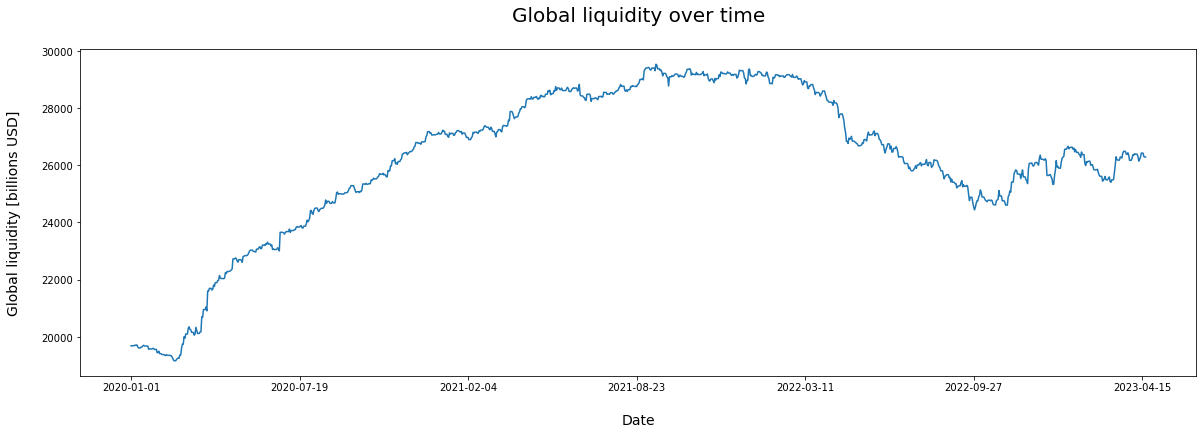

In [54]:
df_liquidity.set_index('date')['liquidity'].plot(figsize=(20, 6))

plt.xlabel('\nDate', fontsize=14)
plt.ylabel('Global liquidity [billions USD]\n', fontsize=14)
plt.title('Global liquidity over time\n', fontsize=20)

In [40]:
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

In [48]:
symbol = '^GSPC'
start = '2020-01-01'
end = '2023-04-04'
interval = '1d'

In [49]:
df = yf.download(tickers=symbol,
                 start=start,
                 end=end,
                 interval=interval,
                 threads=False)

[*********************100%***********************]  1 of 1 completed


In [50]:
df['Date'] = pd.to_datetime(df.index)
df['Date'] = df['Date'].apply(mpl_dates.date2num)
df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df.columns = df.columns.str.lower()

Text(0, 0.5, 'Price\n')

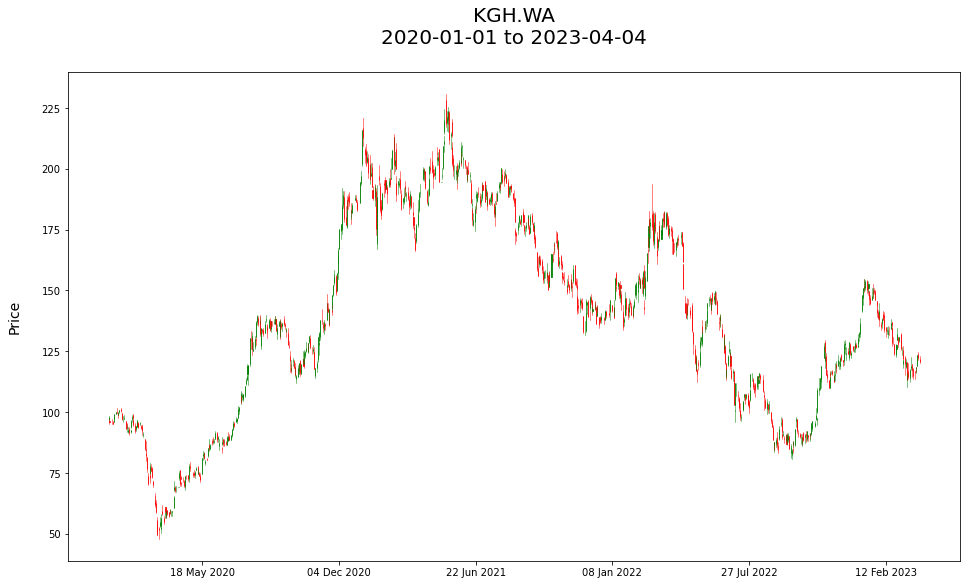

In [51]:
fig, ax = plt.subplots(figsize=(16, 9))   

candlestick_ohlc(ax,
                 df.values,
                 width=0.05,
                 colorup='green',
                 colordown='red', alpha=0.8)

date_format = mpl_dates.DateFormatter('%d %b %Y')

ax.xaxis.set_major_formatter(date_format)    

ax.set_title(f'{symbol}\n{start} to {end}\n', fontsize=20)
ax.set_ylabel('Price\n', fontsize=14)

<AxesSubplot:xlabel='date'>

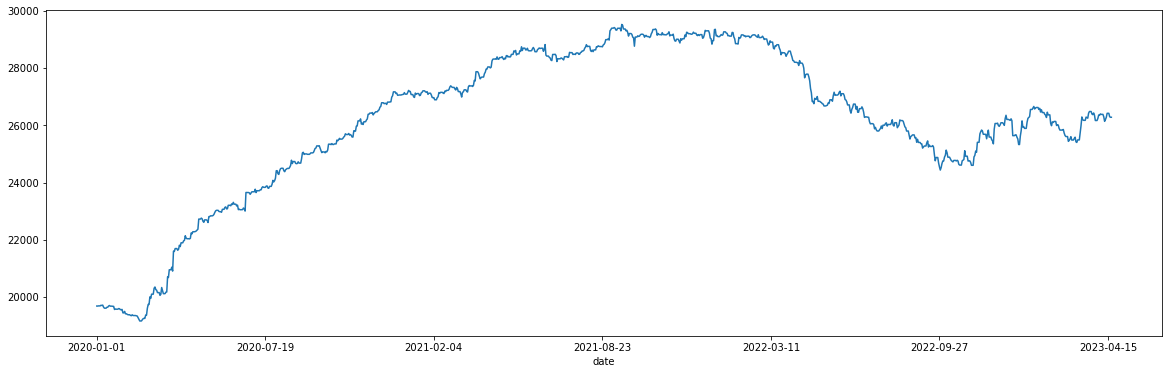

In [45]:
df_liquidity.set_index('date')['liquidity'].plot(figsize=(20, 6))